<a href="https://colab.research.google.com/github/BehrangEbrahimi13/Repo_Paper_01/blob/Autoencoder_In_PyTorch/Autoencoder_In_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation

## Necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Set device

In [3]:
device = ""
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


## Preparing the Training Data

In [4]:
transform = transforms.ToTensor()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)

batch_size = 64
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 132562928.43it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40084610.80it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37321867.83it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23842964.67it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [46]:
count = len(mnist_data)
print("Count of mnist_data:", count)

Count of mnist_data: 60000


tensor(0.) tensor(1.)


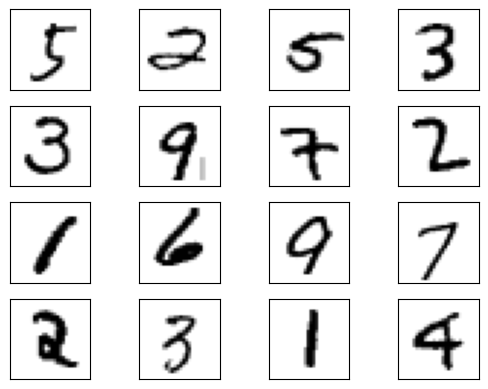

In [5]:
# Obtain a batch of real samples and their corresponding labels from the training loader
real_samples, mnist_lable =  next(iter(data_loader))

print(torch.min(real_samples), torch.max(real_samples))

# Iterate over the first 16 samples in the batch
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])

## Implementing autoencoder (Linear)

In [6]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__();
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3),
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12),
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note: [-1, 1] --> nn.tanh

model = Autoencoder().to(device=device)

### Training the model

In [30]:
lr = 1e-3
weight_decay = 1e-5
num_epochs = 10
outputs = []
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img = img.to(device=device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0262
Epoch:2, Loss:0.0374
Epoch:3, Loss:0.0350
Epoch:4, Loss:0.0351
Epoch:5, Loss:0.0318
Epoch:6, Loss:0.0347
Epoch:7, Loss:0.0331
Epoch:8, Loss:0.0313
Epoch:9, Loss:0.0285
Epoch:10, Loss:0.0333


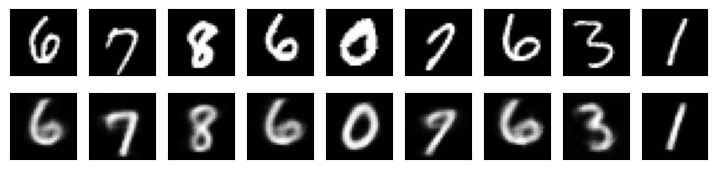

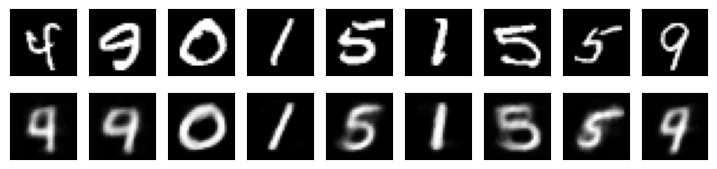

In [32]:
for k in range(0, num_epochs, 5):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        plt.xticks([])
        plt.yticks([])
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        plt.xticks([])
        plt.yticks([])
        # item: 1, 28, 28
        plt.imshow(item[0])

## Implementing autoencoder (Conv)

In [34]:
class Autoencoder_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...

In [40]:
model_conv = Autoencoder_Conv().to(device=device)
lr = 1e-3
weight_decay = 1e-5
num_epochs = 20
outputs_conv = []
criterion_conv = nn.MSELoss()
optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=lr, weight_decay=weight_decay)

In [43]:
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device=device)
        recon_conv = model_conv(img)
        loss_conv = criterion_conv(recon_conv, img)

        optimizer_conv.zero_grad()
        loss_conv.backward()
        optimizer_conv.step()

    print(f'Epoch:{epoch+1}, Loss:{loss_conv.item():.4f}')
    outputs.append((epoch, img, recon_conv))

Epoch:1, Loss:0.0027
Epoch:2, Loss:0.0036
Epoch:3, Loss:0.0026
Epoch:4, Loss:0.0029
Epoch:5, Loss:0.0026
Epoch:6, Loss:0.0028
Epoch:7, Loss:0.0028
Epoch:8, Loss:0.0027
Epoch:9, Loss:0.0024
Epoch:10, Loss:0.0031


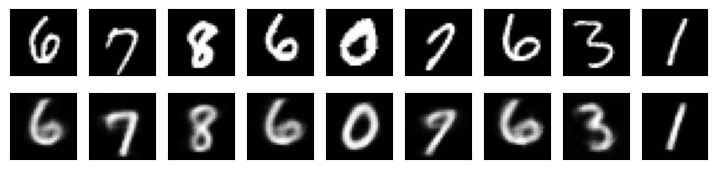

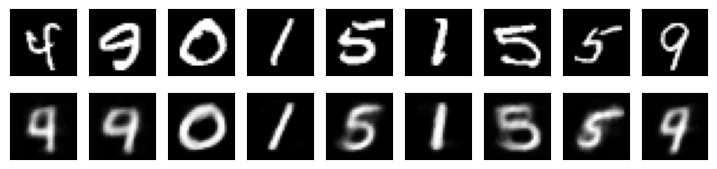

In [44]:
for k in range(0, num_epochs, 5):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])